In [1]:
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


import matplotlib
import pickle

In [2]:
# Load selections and impressions data
selections = pd.read_csv("./data/selections.csv")
impressions = pd.read_csv("./data/impressions.csv")

In [3]:
selections

,userId,movieId,timestamp,session,rank,mo,realAlgo
0,61,824,1681411292,1,0,False,BETA
1,61,1537,1681411294,1,0,True,DELTA
2,61,1433,1681411294,1,1,True,DELTA
3,61,824,1681411311,1,0,False,BETA
4,61,625,1681411317,1,3,False,BETA
...,...,...,...,...,...,...,...
4237,185,1821,1681823000,7,7,True,DELTA
4238,185,1556,1681823032,8,2,True,DELTA
4239,185,1605,1681823036,8,3,True,DELTA
4240,185,1274,1681823039,8,5,True,DELTA


In [4]:
impressions

,userId,movieId,timestamp,session,rank,mo,relevanceGain,diversityGain,noveltyGain,realAlgo
0,61,824,1681411282,1,0,False,1.0000,0.3872,0.5255,BETA
1,61,782,1681411282,1,1,False,0.9964,0.0000,0.6418,BETA
2,61,815,1681411282,1,2,False,0.9959,0.0409,0.6151,BETA
3,61,625,1681411282,1,3,False,0.9952,0.1162,0.5385,BETA
4,61,914,1681411282,1,4,False,0.9949,0.0455,0.6192,BETA
...,...,...,...,...,...,...,...,...,...,...
17015,185,1274,1681823021,8,5,True,0.9663,1.0000,0.7402,DELTA
17016,185,1580,1681823021,8,6,True,0.8775,1.0000,0.8198,DELTA
17017,185,1608,1681823021,8,7,True,0.8167,1.0000,0.8679,DELTA
17018,185,1528,1681823021,8,8,True,0.8682,1.0000,0.8148,DELTA


In [5]:
# Load results for beta fine-tuned on ALL (including multiobjective) selections (ft) vs fine tuned only on beta selections (beta-ft)
ft_no_ft = pd.read_csv("./data/ft_no_ft_comparison.csv")
ft_no_ft_impressions = pd.read_csv("./data/ft_no_ft_recommendations.csv")
ft_impressions = ft_no_ft_impressions[ft_no_ft_impressions.kind == "ft"]
beta_ft_impressions = ft_no_ft_impressions[ft_no_ft_impressions.kind == "beta_ft"]

imp1 = impressions[impressions.mo == False].set_index(["userId", "movieId", "session"])
imp3 = beta_ft_impressions.set_index(["userId", "movieId", "session"])
s1 = selections[selections.mo == False].set_index(["userId", "movieId", "session"])
beta_ft_selections = s1.loc[imp3.index.intersection(s1.index)]

In [6]:
with open("./data/movie_index_to_id.pckl", "rb") as f:
    movie_index_to_id = pickle.load(f)

In [7]:
# Objectives / metrics definitions
import functools
from sklearn.preprocessing import MultiLabelBinarizer, QuantileTransformer, label_binarize

PATH_TO_ML_DATASET_MOVIES_DF = None
# Set path to movies.csv from MovieLens-latest (large)
assert PATH_TO_ML_DATASET_MOVIES_DF is not None, "Please set proper PATH_TO_ML_DATASET_MOVIES_DF"

rating_matrix = np.load("./data/rating_matrix_backup.npy")

def get_year(x):
    res = x.split(" ")[-1].split("(")[-1].split(")")[0]
    try:
        year = int(res)
    except:
        return -1
    return year

movies_info_df = pd.read_csv(PATH_TO_ML_DATASET_MOVIES_DF)
movies_info_df.loc[:, "year"] = movies_info_df.title.map(get_year)
movies_info_df.year = movies_info_df.year.astype(int)
movies_info_df = movies_info_df[movies_info_df.movieId.isin(movie_index_to_id.values())]
movies_info_df = movies_info_df.set_index("movieId")

similarity_matrix = np.load("./data/similarity_matrix_backup.npy")
distance_matrix = 1.0 - similarity_matrix
ratings = pd.read_csv("./data/ratings.csv")
indexedRatings = ratings.set_index(["userId", "session","movieId"])

@functools.cache
def get_all_genres():
    all_genres = set()
    for row in movies_info_df.genres.unique():
        genres = row.split("|")
        all_genres = all_genres.union(genres)
    return all_genres

# !!!!!!!!!!!!
# Multigenre means that multiple genres assigned to a single movie are treated as a single genre

@functools.cache
def get_all_multi_genres():
    return movies_info_df.genres.unique()

year_cdf = QuantileTransformer().fit(movies_info_df.year.values.reshape(-1, 1))
binarizer = MultiLabelBinarizer(classes=list(get_all_genres()))
binarizer = binarizer.fit(None)

# Recall@K
# Rec_list is the list with recommendations
# All user selections are user selections
def recall(rec_list, all_user_selections):
    rec_list_correct = [x for x in rec_list if x in all_user_selections]
    if min(len(all_user_selections), len(rec_list)) == 0:
        return 0.0
    return len(rec_list_correct) / min(len(all_user_selections), len(rec_list))

# Return all genres that given movie has
def get_item_genres(item_index):
    item_id = movie_index_to_id[item_index]
    genres = movies_info_df.loc[item_id].genres.split("|")
    return genres

def get_item_multi_genres(item_index):
    item_id = movie_index_to_id[item_index]
    return movies_info_df.loc[item_id].genres

# Return all genres that all movies in the recommendation list have altogether (union over their genres)
def get_list_genres(rec_list, get_item_genres_f):
    all_genres = set()
    for item in rec_list:
        all_genres = all_genres.union(get_item_genres_f(item))
    return all_genres

def topic_coverage(rec_list, get_item_genres_f, get_all_genres_f):
    rec_list_genres = get_list_genres(rec_list, get_item_genres_f)

    return len(rec_list_genres) / len(get_all_genres_f())

def collaborative_diversity(item_a, item_b):
    if item_b is None:
        return distance_matrix[item_a].sum() / (distance_matrix.shape[0] - 1)
    return distance_matrix[item_a, item_b]

def content_based_diversity(item_a, item_b):
    if item_b is None:
        return 0.0
    #inpt = [list(get_item_genres(item_a)), list(get_item_genres(item_b))]
    #res = binarizer.fit_transform(inpt)
    res = binarizer.transform([get_item_genres(item_a), get_item_genres(item_b)])
    cos_sim = (cosine_similarity(res[0], res[1]) + 1) / 2 # Convert from [-1, 1] to [0, 1]
    return 1 - cos_sim # Convert to distance


def content_based_diversity_multigenre(item_a, item_b):
    res = label_binarize([get_item_multi_genres(item_a), get_item_multi_genres(item_b)], classes=get_all_multi_genres())
    cos_sim = (cosine_similarity(res[0], res[1]) + 1) / 2 # Convert from [-1, 1] to [0, 1]
    return 1 - cos_sim # Convert to distance

def inverse_popularity(item):
    return (-1 * (np.sum(rating_matrix > 0.0, axis=0) / rating_matrix.shape[0])[item]).mean()
    
def get_item_year(item):
    item_id = movie_index_to_id[item]
    return movies_info_df.loc[item_id].year
    
def temporal_novelty(items):
    x = [year_cdf.transform([[get_item_year(item)]]).squeeze() for item in items]
    return sum(x) / len(x)
    
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
    
def intra_list_diversity(rec_list, div_func):
    assert len(rec_list) > 0
    n = len(rec_list)
    div = 0
    
    if n == 1:
        return div_func(rec_list[0], None) # Overload to calculate mean diversity of an item
    
    for i in range(n):
        for j in range(i):
            div += div_func(rec_list[i], rec_list[j])
    return div / ((n - 1) * n / 2)

def get_mean_relevance(rec_list, user, session):
    idx = list(zip([user]*len(rec_list),[session]*len(rec_list),rec_list))
    idxValidity = [i in indexedRatings.index for i in idx]
    idx = np.array(idx)[idxValidity].tolist()
    
    return indexedRatings.loc[idx,"rawRating"].mean()

def mean_relevance_per_session(rec_list, userId, session):
    return np.array([ratings_indexed.loc[(userId, session, item)].rawRating for item in rec_list]).mean()

def list_novelty(rec_list, nov_func):
    assert len(rec_list) > 0
    
    n = len(rec_list)
    nov = 0    
    for i in range(n):
        nov += nov_func(rec_list[i])
    return nov / n

### Calculate per session objectives on impressions

In [8]:
# Final result generation
obj_comparison = pd.DataFrame(columns=["userId", "value", "objective", "kind"])


# Impressions Coverage
dv = beta_ft_impressions.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: topic_coverage(x.astype(int).tolist(), get_item_genres, get_all_genres)}) \
    .reset_index().rename(columns={"movieId": "Coverage"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "Coverage"
dv.loc[:, "source"] = "impressions"
dv = dv.rename(columns={"Coverage": "value"})

dv2 = imp1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: topic_coverage(x.astype(int).tolist(), get_item_genres, get_all_genres)}) \
    .reset_index().rename(columns={"movieId": "Coverage"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "Coverage"
dv2.loc[:, "source"] = "impressions"
dv2 = dv2.rename(columns={"Coverage": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])


# Impressions ILD
dv = beta_ft_impressions.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), collaborative_diversity)}) \
    .reset_index().rename(columns={"movieId": "ILD"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "ILD"
dv.loc[:, "source"] = "impressions"
dv = dv.rename(columns={"ILD": "value"})

dv2 = imp1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), collaborative_diversity)}) \
    .reset_index().rename(columns={"movieId": "ILD"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "ILD"
dv2.loc[:, "source"] = "impressions"
dv2 = dv2.rename(columns={"ILD": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])



# Impressions CB-ILD
dv = beta_ft_impressions.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), content_based_diversity)}) \
    .reset_index().rename(columns={"movieId": "CB-ILD"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "CB-ILD"
dv.loc[:, "source"] = "impressions"
dv = dv.rename(columns={"CB-ILD": "value"})

dv2 = imp1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), content_based_diversity)}) \
    .reset_index().rename(columns={"movieId": "CB-ILD"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "CB-ILD"
dv2.loc[:, "source"] = "impressions"
dv2 = dv2.rename(columns={"CB-ILD": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])



# Impressions Novelty
dv = beta_ft_impressions.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: inverse_popularity(x.astype(int).tolist())}) \
    .reset_index().rename(columns={"movieId": "novelty"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "novelty"
dv.loc[:, "source"] = "impressions"
dv = dv.rename(columns={"novelty": "value"})

dv2 = imp1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: inverse_popularity(x.astype(int).tolist())}) \
    .reset_index().rename(columns={"movieId": "novelty"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "novelty"
dv2.loc[:, "source"] = "impressions"
dv2 = dv2.rename(columns={"novelty": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])


# Impressions Temporal Novelty
dv = beta_ft_impressions.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: temporal_novelty(x.astype(int).tolist())}) \
    .reset_index().rename(columns={"movieId": "TemporalNovelty"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "TemporalNovelty"
dv.loc[:, "source"] = "impressions"
dv = dv.rename(columns={"TemporalNovelty": "value"})

dv2 = imp1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: temporal_novelty(x.astype(int).tolist())}) \
    .reset_index().rename(columns={"movieId": "TemporalNovelty"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "TemporalNovelty"
dv2.loc[:, "source"] = "impressions"
dv2 = dv2.rename(columns={"TemporalNovelty": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])

### Calculate objectives on selections

In [9]:
# Selections Coverage
dv = beta_ft_selections.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: topic_coverage(x.astype(int).tolist(), get_item_genres, get_all_genres)}) \
    .rename(columns={"movieId": "Coverage"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "Coverage"
dv.loc[:, "source"] = "selections_overall"
dv = dv.rename(columns={"Coverage": "value"})

dv2 = s1.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: topic_coverage(x.astype(int).tolist(), get_item_genres, get_all_genres)}) \
    .rename(columns={"movieId": "Coverage"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "Coverage"
dv2.loc[:, "source"] = "selections_overall"
dv2 = dv2.rename(columns={"Coverage": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])

# Selections ILD
dv = beta_ft_selections.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), collaborative_diversity)}) \
    .rename(columns={"movieId": "ILD"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "ILD"
dv.loc[:, "source"] = "selections_overall"
dv = dv.rename(columns={"ILD": "value"})

dv2 = s1.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), collaborative_diversity)}) \
    .rename(columns={"movieId": "ILD"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "ILD"
dv2.loc[:, "source"] = "selections_overall"
dv2 = dv2.rename(columns={"ILD": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])

# Selections CB-ILD
dv = beta_ft_selections.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), content_based_diversity)}) \
    .rename(columns={"movieId": "CB-ILD"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "CB-ILD"
dv.loc[:, "source"] = "selections_overall"
dv = dv.rename(columns={"CB-ILD": "value"})

dv2 = s1.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), content_based_diversity)}) \
    .rename(columns={"movieId": "CB-ILD"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "CB-ILD"
dv2.loc[:, "source"] = "selections_overall"
dv2 = dv2.rename(columns={"CB-ILD": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])


# Selections Novelty
dv = beta_ft_selections.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: inverse_popularity(x.astype(int).tolist())}) \
    .rename(columns={"movieId": "novelty"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "novelty"
dv.loc[:, "source"] = "selections_overall"
dv = dv.rename(columns={"novelty": "value"})

dv2 = s1.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: inverse_popularity(x.astype(int).tolist())}) \
    .rename(columns={"movieId": "novelty"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "novelty"
dv2.loc[:, "source"] = "selections_overall"
dv2 = dv2.rename(columns={"novelty": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])

# Selections temporal novelty, not per session
dv = beta_ft_selections.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: temporal_novelty(x.astype(int).tolist())}) \
    .rename(columns={"movieId": "TemporalNovelty"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "TemporalNovelty"
dv.loc[:, "source"] = "selections_overall"
dv = dv.rename(columns={"TemporalNovelty": "value"})

dv2 = s1.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: temporal_novelty(x.astype(int).tolist())}) \
    .rename(columns={"movieId": "TemporalNovelty"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "TemporalNovelty"
dv2.loc[:, "source"] = "selections_overall"
dv2 = dv2.rename(columns={"TemporalNovelty": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])

In [10]:
obj_comparison

,userId,value,objective,kind,index,session,source
0,60,0.300000,Coverage,ft,0.0,1.0,impressions
1,60,0.400000,Coverage,ft,1.0,2.0,impressions
2,60,0.650000,Coverage,ft,2.0,3.0,impressions
3,60,0.650000,Coverage,ft,3.0,4.0,impressions
4,60,0.600000,Coverage,ft,4.0,5.0,impressions
...,...,...,...,...,...,...,...
97,181,0.746175,TemporalNovelty,beta_ft,NaN,NaN,selections_overall
98,182,0.465883,TemporalNovelty,beta_ft,NaN,NaN,selections_overall
99,183,0.729622,TemporalNovelty,beta_ft,NaN,NaN,selections_overall
100,184,0.516806,TemporalNovelty,beta_ft,NaN,NaN,selections_overall


In [11]:
# Utility function for increasing font size in plots
def increase_font_size(scale=1.5):
    font_keys = ["axes.labelsize", "axes.titlesize", "legend.fontsize",
             "xtick.labelsize", "ytick.labelsize", "font.size"]
    font_dict = {k: matplotlib.rcParams[k] * scale if k == "font.size" else "x-large" for k in font_keys}
    matplotlib.rcParams.update(font_dict)

In [57]:
# Increase font size in plots
sns.reset_defaults()
increase_font_size(1.5)

### Generate results plot for beta-ft and ft (including multi-objective selections) variants

In [14]:
# Results filtering function
def f_r(objective, kind, source):
    return obj_comparison[(obj_comparison.objective == objective) & (obj_comparison.kind == kind) & (obj_comparison.source == source)].value

# Mapping objective names to more readable form
def map_obj_name(x):
    if x == "novelty":
        return "Novelty"
    elif x == "TemporalNovelty":
        return "Temporal Novelty"
    elif x == "ILD":
        return "CL-ILD"
    else:
        return x

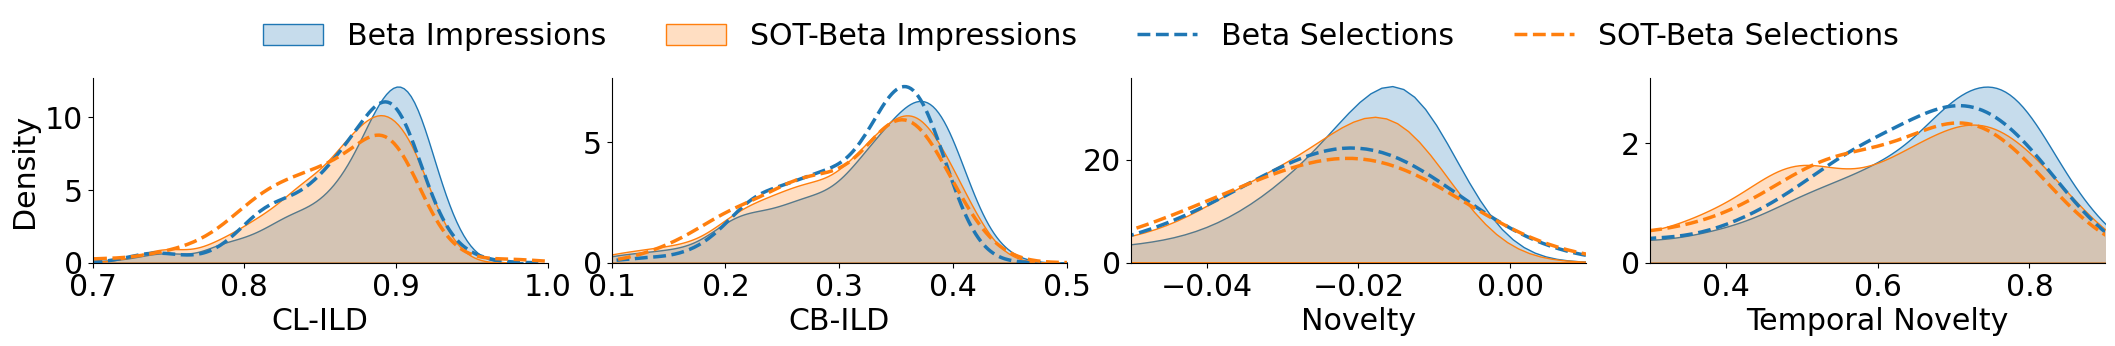

In [58]:
obj_comparison.objective = obj_comparison.objective.map(lambda x: map_obj_name(x))
g = sns.FacetGrid(data=obj_comparison[obj_comparison.objective != "Coverage"], col="objective", legend_out=True, height=3, sharey=False, sharex=False)

g.set_titles(col_template="")

g.fig.set_figwidth(4.5 * 5)

g.fig.subplots_adjust(hspace=0.125, wspace=0.140)


g2 = sns.kdeplot(
    x=f_r("CL-ILD", "ft", "impressions"),
    fill=True, ax=g.axes[0, 0], common_norm=True
)
g2.set(xlim=(0.7, 1.0))

g2 = sns.kdeplot(
    x=f_r("CL-ILD", "beta_ft", "impressions"),
    fill=True, ax=g.axes[0, 0], common_norm=True #g.ax_joint
)
g2.set(xlim=(0.7, 1.0))

g2 = sns.kdeplot(
    x=f_r("CL-ILD", "ft", "selections_overall"),
    fill=False, ax=g.axes[0, 0], linestyle="--", linewidth=2.5, common_norm=True
)
g2.set(xlim=(0.7, 1.0))

g2 = sns.kdeplot(
    x=f_r("CL-ILD", "beta_ft", "selections_overall"),
    fill=False, ax=g.axes[0, 0], linestyle="--", linewidth=2.5, common_norm=True
)
g2.set(xlim=(0.7, 1.0))


g2 = sns.kdeplot(
    x=f_r("CB-ILD", "ft", "impressions"),
    fill=True, ax=g.axes[0, 1], common_norm=True
)
g2.set(xlim=(0.1, 0.5))

g2 = sns.kdeplot(
    x=f_r("CB-ILD", "beta_ft", "impressions"),
    fill=True, ax=g.axes[0, 1], common_norm=True #g.ax_joint
)
g2.set(xlim=(0.1, 0.5))

g2 = sns.kdeplot(
    x=f_r("CB-ILD", "ft", "selections_overall"),
    fill=False, ax=g.axes[0, 1], linestyle="--", linewidth=2.5, common_norm=True
)
g2.set(xlim=(0.1, 0.5))

g2 = sns.kdeplot(
    x=f_r("CB-ILD", "beta_ft", "selections_overall"),
    fill=False, ax=g.axes[0, 1], linestyle="--", linewidth=2.5, common_norm=True
)
g2.set(xlim=(0.1, 0.5))



g2 = sns.kdeplot(
    x=f_r("Novelty", "ft", "impressions"),
    fill=True, ax=g.axes[0, 2], common_norm=True
)
g2.set(xlim=(-0.05, 0.01))

g2 = sns.kdeplot(
    x=f_r("Novelty", "beta_ft", "impressions"),
    fill=True, ax=g.axes[0, 2], common_norm=True #g.ax_joint
)
g2.set(xlim=(-0.05, 0.01))

g2 = sns.kdeplot(
    x=f_r("Novelty", "ft", "selections_overall"),
    fill=False, ax=g.axes[0, 2], linestyle="--", linewidth=2.5, common_norm=True
)
g2.set(xlim=(-0.05, 0.01))

g2 = sns.kdeplot(
    x=f_r("Novelty", "beta_ft", "selections_overall"),
    fill=False, ax=g.axes[0, 2], linestyle="--", linewidth=2.5, common_norm=True
)
g2.set(xlim=(-0.05, 0.01))



g2 = sns.kdeplot(
    x=f_r("Temporal Novelty", "ft", "impressions"),
    fill=True, ax=g.axes[0, 3], common_norm=True,
    label="Beta Impressions"
)
g2.set(xlim=(0.3, 0.9))
g2 = sns.kdeplot(
    x=f_r("Temporal Novelty", "beta_ft", "impressions"),
    fill=True, ax=g.axes[0, 3], common_norm=True, #g.ax_joint
    label="SOT-Beta Impressions"
)
g2.set(xlim=(0.3, 0.9))

g2 = sns.kdeplot(
    x=f_r("Temporal Novelty", "ft", "selections_overall"),
    fill=False, ax=g.axes[0, 3], linestyle="--", linewidth=2.5, common_norm=False,
    label="Beta Selections"
)
g2.set(xlim=(0.3, 0.9))

g2 = sns.kdeplot(
    x=f_r("Temporal Novelty", "beta_ft", "selections_overall"),
    fill=False, ax=g.axes[0, 3], linestyle="--", linewidth=2.5, common_norm=False,
    label="SOT-Beta Selections"
)
g2.set(xlim=(0.3, 0.9))


g.axes[0,1].set_ylabel('')
g.axes[0,2].set_ylabel('')
g.axes[0,3].set_ylabel('')

g.axes[0,0].set_xlabel('CL-ILD')
g.axes[0,1].set_xlabel('CB-ILD')
g.axes[0,2].set_xlabel('Novelty')
g.axes[0,3].set_xlabel('Temporal Novelty')

g.axes[0][3].legend(loc='lower center', bbox_to_anchor=(-1.25, 1.0), ncol=4, frameon=False, title=None)


plt.tight_layout()
plt.savefig("./results/ft_no_ft_obj_comparison_final.pdf", bbox_inches="tight")

### Statistical significance tests and numeric results

#### <font color='red'>Note that 'ft' here corresponds to 'Beta' in paper, while beta_ft is 'SOT-Beta'</font>

In [21]:
# Collaborative diversity on impressions
print(f_r("CL-ILD", "ft", "impressions").mean())
print(f_r("CL-ILD", "beta_ft", "impressions").mean())
print(ttest_ind(f_r("CL-ILD", "ft", "impressions"), f_r("CL-ILD", "beta_ft", "impressions"), alternative="greater"))

0.8763641637609085
0.8640043714976728
Ttest_indResult(statistic=5.405114744065051, pvalue=3.694334812807821e-08)


In [22]:
# Collaborative diversity on selections
print(f_r("CL-ILD", "ft", "selections_overall").mean())
print(f_r("CL-ILD", "beta_ft", "selections_overall").mean())
print(ttest_ind(f_r("CL-ILD", "ft", "selections_overall"), f_r("CL-ILD", "beta_ft", "selections_overall"), alternative="greater"))

0.8689418904797928
0.8570127641693398
Ttest_indResult(statistic=1.9246583606896162, pvalue=0.027838510467556716)


In [23]:
# Content-based diversity on impressions
print(f_r("CB-ILD", "ft", "impressions").mean())
print(f_r("CB-ILD", "beta_ft", "impressions").mean())
print(ttest_ind(f_r("CB-ILD", "ft", "impressions"), f_r("CB-ILD", "beta_ft", "impressions"), alternative="greater"))

0.32302881564254865
0.3121645282312198
Ttest_indResult(statistic=3.0814802389879334, pvalue=0.0010462989246728149)


In [30]:
# Content-based diversity on selections
print(f_r("CB-ILD", "ft", "selections_overall").mean())
print(f_r("CB-ILD", "beta_ft", "selections_overall").mean())
print(ttest_ind(f_r("CB-ILD", "ft", "selections_overall"), f_r("CB-ILD", "beta_ft", "selections_overall"), alternative="greater"))

0.3156343916391949
0.30657607633511613
Ttest_indResult(statistic=0.9586360757493702, pvalue=0.16944404502487742)


In [31]:
# Novelty on impressions
print(f_r("Novelty", "ft", "impressions").mean())
print(f_r("Novelty", "beta_ft", "impressions").mean())
print(ttest_ind(f_r("Novelty", "ft", "impressions"), f_r("Novelty", "beta_ft", "impressions"), alternative="greater"))

-0.02718876704898511
-0.03172268982552329
Ttest_indResult(statistic=3.7588639116743923, pvalue=8.82109011005072e-05)


In [32]:
# Novelty on selections
print(f_r("Novelty", "ft", "selections_overall").mean())
print(f_r("Novelty", "beta_ft", "selections_overall").mean())
print(ttest_ind(f_r("Novelty", "ft", "selections_overall"), f_r("Novelty", "beta_ft", "selections_overall"), alternative="greater"))

-0.034840818752213516
-0.036485950226700925
Ttest_indResult(statistic=0.4011925494585022, pvalue=0.34435121804251445)


In [29]:
# Temporal novelty on impressions
print(f_r("Temporal Novelty", "ft", "impressions").mean())
print(f_r("Temporal Novelty", "beta_ft", "impressions").mean())
print(ttest_ind(f_r("Temporal Novelty", "ft", "impressions"), f_r("Temporal Novelty", "beta_ft", "impressions"), alternative="greater"))

0.6472267668612007
0.6062541708375042
Ttest_indResult(statistic=4.905787790230575, pvalue=5.09474719957843e-07)


In [28]:
# Temporal novelty on selections
print(f_r("Temporal Novelty", "ft", "selections_overall").mean())
print(f_r("Temporal Novelty", "beta_ft", "selections_overall").mean())
print(ttest_ind(f_r("Temporal Novelty", "ft", "selections_overall"), f_r("Temporal Novelty", "beta_ft", "selections_overall"), alternative="greater"))

0.6251293678223863
0.6030072431406338
Ttest_indResult(statistic=0.9330625730543836, pvalue=0.17595079835660876)


In [26]:
# Coverage on impressions
print(f_r("Coverage", "ft", "impressions").mean())
print(f_r("Coverage", "beta_ft", "impressions").mean())
print(ttest_ind(f_r("Coverage", "ft", "impressions"), f_r("Coverage", "beta_ft", "impressions"), alternative="greater"))

0.4838443396226415
0.4784722222222222
Ttest_indResult(statistic=1.0395564200891985, pvalue=0.14934649747403625)


In [25]:
# Coverage on selections
print(f_r("Coverage", "ft", "selections_overall").mean())
print(f_r("Coverage", "beta_ft", "selections_overall").mean())
print(ttest_ind(f_r("Coverage", "ft", "selections_overall"), f_r("Coverage", "beta_ft", "selections_overall"), alternative="greater"))

0.6176470588235294
0.5583333333333332
Ttest_indResult(statistic=3.076755822337036, pvalue=0.001191368745803905)


## Per algo objectives on impressions

In [33]:
# Collaborative diversity
x = impressions.groupby(["userId", "session", "realAlgo"])\
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), collaborative_diversity)})\
    .rename(columns={"movieId": "ILD"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"].ILD, x[x.realAlgo == "GAMMA"].ILD))
print(ttest_ind(x[x.realAlgo == "BETA"].ILD, x[x.realAlgo == "DELTA"].ILD))
print(ttest_ind(x[x.realAlgo == "DELTA"].ILD, x[x.realAlgo == "GAMMA"].ILD))

x.groupby("realAlgo").mean()

Ttest_indResult(statistic=-45.3091702088645, pvalue=1.6013119227401308e-267)
Ttest_indResult(statistic=-30.14913924297638, pvalue=4.62456232613858e-151)
Ttest_indResult(statistic=-10.05012124915448, pvalue=1.587111026568734e-22)


,userId,session,ILD
realAlgo,,,
BETA,125.132075,4.500000,0.876364
DELTA,125.132075,4.198113,0.961355
GAMMA,125.132075,4.801887,0.987506


In [34]:
# Content based diversity
x = impressions.groupby(["userId", "session", "realAlgo"])\
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), content_based_diversity)})\
    .rename(columns={"movieId": "CB-ILD"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"]["CB-ILD"], x[x.realAlgo == "GAMMA"]["CB-ILD"]))
print(ttest_ind(x[x.realAlgo == "BETA"]["CB-ILD"], x[x.realAlgo == "DELTA"]["CB-ILD"]))
print(ttest_ind(x[x.realAlgo == "DELTA"]["CB-ILD"], x[x.realAlgo == "GAMMA"]["CB-ILD"]))

x.groupby("realAlgo").mean()

Ttest_indResult(statistic=-16.28415293851146, pvalue=2.7226642030020007e-54)
Ttest_indResult(statistic=-11.02623788084828, pvalue=4.611734180149248e-27)
Ttest_indResult(statistic=-4.4159756540209765, pvalue=1.1358760032482197e-05)


,userId,session,CB-ILD
realAlgo,,,
BETA,125.132075,4.500000,0.323029
DELTA,125.132075,4.198113,0.368708
GAMMA,125.132075,4.801887,0.385312


In [35]:
# Coverage
x = impressions.groupby(["userId", "session", "realAlgo"])\
    .agg({"movieId": lambda x: topic_coverage(x.astype(int).tolist(), get_item_genres, get_all_genres)})\
    .rename(columns={"movieId": "Coverage"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"].Coverage, x[x.realAlgo == "GAMMA"].Coverage))
print(ttest_ind(x[x.realAlgo == "BETA"].Coverage, x[x.realAlgo == "DELTA"].Coverage))
print(ttest_ind(x[x.realAlgo == "DELTA"].Coverage, x[x.realAlgo == "GAMMA"].Coverage))

x.groupby("realAlgo").mean()

Ttest_indResult(statistic=0.32820092133045614, pvalue=0.742813852580365)
Ttest_indResult(statistic=-1.9441634313936746, pvalue=0.05209632721444961)
Ttest_indResult(statistic=2.059392516874623, pvalue=0.03976217821595282)


,userId,session,Coverage
realAlgo,,,
BETA,125.132075,4.500000,0.483844
DELTA,125.132075,4.198113,0.495991
GAMMA,125.132075,4.801887,0.481840


In [36]:
# Novelty
x = impressions.groupby(["userId", "session", "realAlgo"])\
    .agg({"movieId": lambda x: inverse_popularity(x.astype(int).tolist())})\
    .rename(columns={"movieId": "Novelty"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"].Novelty, x[x.realAlgo == "GAMMA"].Novelty))
print(ttest_ind(x[x.realAlgo == "BETA"].Novelty, x[x.realAlgo == "DELTA"].Novelty))
print(ttest_ind(x[x.realAlgo == "DELTA"].Novelty, x[x.realAlgo == "GAMMA"].Novelty))

x.groupby("realAlgo").mean()

Ttest_indResult(statistic=-19.45248080914304, pvalue=5.61234298148812e-74)
Ttest_indResult(statistic=-11.583730567359337, pvalue=1.4387504397216695e-29)
Ttest_indResult(statistic=-7.234974138731884, pvalue=1.04408091036521e-12)


,userId,session,Novelty
realAlgo,,,
BETA,125.132075,4.500000,-0.027189
DELTA,125.132075,4.198113,-0.011250
GAMMA,125.132075,4.801887,-0.003672


In [37]:
# Temporal Novelty
x = impressions.groupby(["userId", "session", "realAlgo"])\
    .agg({"movieId": lambda x: temporal_novelty(x.astype(int).tolist())})\
    .rename(columns={"movieId": "Temporal Novelty"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"]["Temporal Novelty"], x[x.realAlgo == "GAMMA"]["Temporal Novelty"]))
print(ttest_ind(x[x.realAlgo == "BETA"]["Temporal Novelty"], x[x.realAlgo == "DELTA"]["Temporal Novelty"]))
print(ttest_ind(x[x.realAlgo == "DELTA"]["Temporal Novelty"], x[x.realAlgo == "GAMMA"]["Temporal Novelty"]))

x.groupby("realAlgo").mean()

Ttest_indResult(statistic=-32.60710673801104, pvalue=6.071668575194559e-170)
Ttest_indResult(statistic=-21.37966060243207, pvalue=7.211754698770926e-87)
Ttest_indResult(statistic=-8.72691435112006, pvalue=1.3770637235205276e-17)


,userId,session,Temporal Novelty
realAlgo,,,
BETA,125.132075,4.500000,0.647227
DELTA,125.132075,4.198113,0.855703
GAMMA,125.132075,4.801887,0.932003


## Per algo objectives on selections

In [38]:
# Collaborative diversity
x = selections.groupby(["userId", "realAlgo"])\
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), collaborative_diversity)})\
    .rename(columns={"movieId": "ILD"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"].ILD, x[x.realAlgo == "GAMMA"].ILD))
print(ttest_ind(x[x.realAlgo == "BETA"].ILD, x[x.realAlgo == "DELTA"].ILD))
print(ttest_ind(x[x.realAlgo == "DELTA"].ILD, x[x.realAlgo == "GAMMA"].ILD))

x.groupby("realAlgo").mean()

Ttest_indResult(statistic=-18.919432665400148, pvalue=2.878603540772442e-46)
Ttest_indResult(statistic=-10.344864261424066, pvalue=2.6094159479609495e-20)
Ttest_indResult(statistic=-2.3466400605983635, pvalue=0.01995750163331993)


,userId,ILD
realAlgo,,
BETA,125.950980,0.868942
DELTA,125.381443,0.947556
GAMMA,126.775510,0.964190


In [39]:
# Content based diversity
x = selections.groupby(["userId", "realAlgo"])\
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), content_based_diversity)})\
    .rename(columns={"movieId": "CB-ILD"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"]["CB-ILD"], x[x.realAlgo == "GAMMA"]["CB-ILD"]))
print(ttest_ind(x[x.realAlgo == "BETA"]["CB-ILD"], x[x.realAlgo == "DELTA"]["CB-ILD"]))
print(ttest_ind(x[x.realAlgo == "DELTA"]["CB-ILD"], x[x.realAlgo == "GAMMA"]["CB-ILD"]))

x.groupby("realAlgo").mean()

Ttest_indResult(statistic=-0.16538196046713594, pvalue=0.8688120851618845)
Ttest_indResult(statistic=0.2664939660749574, pvalue=0.7901375362547869)
Ttest_indResult(statistic=-0.33325117259942333, pvalue=0.7393064414443038)


,userId,CB-ILD
realAlgo,,
BETA,125.950980,0.315634
DELTA,125.381443,0.311878
GAMMA,126.775510,0.317902


In [40]:
# Coverage
x = selections.groupby(["userId", "realAlgo"])\
    .agg({"movieId": lambda x: topic_coverage(x.astype(int).tolist(), get_item_genres, get_all_genres)})\
    .rename(columns={"movieId": "Coverage"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"].Coverage, x[x.realAlgo == "GAMMA"].Coverage))
print(ttest_ind(x[x.realAlgo == "BETA"].Coverage, x[x.realAlgo == "DELTA"].Coverage))
print(ttest_ind(x[x.realAlgo == "DELTA"].Coverage, x[x.realAlgo == "GAMMA"].Coverage))

x.groupby("realAlgo").mean()

Ttest_indResult(statistic=13.916899784161851, pvalue=3.7447645172619035e-31)
Ttest_indResult(statistic=11.334566476400923, pvalue=2.985390936186096e-23)
Ttest_indResult(statistic=1.2713618600462862, pvalue=0.20512998156749404)


,userId,Coverage
realAlgo,,
BETA,125.950980,0.617647
DELTA,125.381443,0.377320
GAMMA,126.775510,0.348980


In [41]:
# Novelty
x = selections.groupby(["userId", "realAlgo"])\
    .agg({"movieId": lambda x: inverse_popularity(x.astype(int).tolist())})\
    .rename(columns={"movieId": "Novelty"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"].Novelty, x[x.realAlgo == "GAMMA"].Novelty))
print(ttest_ind(x[x.realAlgo == "BETA"].Novelty, x[x.realAlgo == "DELTA"].Novelty))
print(ttest_ind(x[x.realAlgo == "DELTA"].Novelty, x[x.realAlgo == "GAMMA"].Novelty))

x.groupby("realAlgo").mean()

Ttest_indResult(statistic=-7.127324491906416, pvalue=1.8657278957547843e-11)
Ttest_indResult(statistic=-7.101958642613554, pvalue=2.1871589487710672e-11)
Ttest_indResult(statistic=-0.7753842205707064, pvalue=0.43906167473361335)


,userId,Novelty
realAlgo,,
BETA,125.950980,-0.034841
DELTA,125.381443,-0.010344
GAMMA,126.775510,-0.007963


In [42]:
# Temporal Novelty
x = selections.groupby(["userId", "realAlgo"])\
    .agg({"movieId": lambda x: temporal_novelty(x.astype(int).tolist())})\
    .rename(columns={"movieId": "Temporal Novelty"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"]["Temporal Novelty"], x[x.realAlgo == "GAMMA"]["Temporal Novelty"]))
print(ttest_ind(x[x.realAlgo == "BETA"]["Temporal Novelty"], x[x.realAlgo == "DELTA"]["Temporal Novelty"]))
print(ttest_ind(x[x.realAlgo == "DELTA"]["Temporal Novelty"], x[x.realAlgo == "GAMMA"]["Temporal Novelty"]))

x.groupby("realAlgo").mean()

Ttest_indResult(statistic=-12.422614455362163, pvalue=1.42059088387426e-26)
Ttest_indResult(statistic=-9.974180521857145, pvalue=3.1609552675179076e-19)
Ttest_indResult(statistic=-1.6905048315453282, pvalue=0.09254577682824247)


,userId,Temporal Novelty
realAlgo,,
BETA,125.950980,0.625129
DELTA,125.381443,0.858068
GAMMA,126.775510,0.895819


## Marginal gains analysis and additional data preprocessing

In [43]:
dfWeights = pd.read_csv("./data/weights.csv")

In [44]:
dfImpressions = impressions.copy()
dfSelections = selections.copy()

dfShownImpressions = dfImpressions

In [45]:
#all items that were (would be) shown by some algorithm in that particular session and were selected (no matter if the selection was made on that particular algorithm or not)
dfEnhancedSelections = dfImpressions.set_index(["userId","movieId","session"]).join(dfSelections.set_index(["userId","movieId","session"]), rsuffix="_selection", how="inner")

In [46]:
dfShownSelections = dfEnhancedSelections

In [47]:
#takes couple minutes to calculate
dfShownImpressions["movieId"] = dfShownImpressions["movieId"].astype(int)

dfGroupedImpressions = dfShownImpressions.groupby(["userId","session","realAlgo"])["movieId"].apply(list).reset_index()
collDiv = []
cbDiv = []
cbDivMG = []
intNov = []
tempNov = []
for idx, row in dfGroupedImpressions.iterrows():
    collDiv.append(intra_list_diversity(row["movieId"],collaborative_diversity))
    cbDiv.append(intra_list_diversity(row["movieId"],content_based_diversity))
    cbDivMG.append(intra_list_diversity(row["movieId"],content_based_diversity_multigenre))
    intNov.append(list_novelty(row["movieId"],inverse_popularity))
    tempNov.append(temporal_novelty(row["movieId"]))
    
dfGroupedImpressions["collDiv"] = collDiv
dfGroupedImpressions["cbDiv"] = cbDiv
dfGroupedImpressions["intNov"] = intNov
dfGroupedImpressions["tempNov"] = tempNov
dfGroupedImpressions["cbDivMG"] = cbDivMG

In [48]:
relevance = []
for idx, row in dfGroupedImpressions.iterrows():
    relevance.append(get_mean_relevance(row["movieId"],row["userId"],row["session"]))   
dfGroupedImpressions["relevance"] = relevance

dfGroupedImpressions

,userId,session,realAlgo,movieId,collDiv,cbDiv,intNov,tempNov,cbDivMG,relevance
0,60,1,BETA,"[1595, 1489, 1423, 1359, 1339, 1455, 1860, 145...",0.890129,0.169690,-0.027569,0.838739,0.322222,1.548370
1,60,1,GAMMA,"[1856, 1793, 1816, 1720, 1833, 1292, 1339, 148...",0.969161,0.233497,-0.003800,0.888288,0.333333,1.390141
2,60,2,BETA,"[1756, 1702, 1434, 1726, 1573, 1494, 1428, 162...",0.914607,0.391049,-0.008679,0.900901,0.477778,2.008837
3,60,2,GAMMA,"[1701, 1756, 1703, 1769, 1616, 1633, 1555, 161...",0.998568,0.316272,-0.000848,1.000000,0.355556,1.319438
4,60,3,BETA,"[1715, 1885, 1797, 1402, 1497, 1454, 1676, 171...",0.911371,0.415268,-0.007589,0.888288,0.488889,1.976296
...,...,...,...,...,...,...,...,...,...,...
1691,185,6,DELTA,"[1827, 1713, 1553, 1790, 1610, 1617, 1768, 173...",0.994839,0.395479,-0.000705,1.000000,0.488889,0.762308
1692,185,7,BETA,"[1226, 1107, 1511, 1304, 1166, 1216, 1108, 665...",0.897384,0.348503,-0.021247,0.616216,0.477778,1.678634
1693,185,7,DELTA,"[1759, 1511, 1434, 1647, 1620, 1320, 1824, 182...",1.000000,0.373505,-0.001608,0.919369,0.488889,0.698755
1694,185,8,BETA,"[1163, 1342, 258, 1326, 1106, 1386, 1084, 679,...",0.854123,0.369580,-0.035246,0.538739,0.500000,1.579908


In [49]:
dfShownSelections = dfShownSelections.reset_index()
dfShownSelections["movieId"] = dfShownSelections["movieId"].astype(int)

In [50]:
#takes couple minutes to calculate
dfGroupedSelections = dfShownSelections.groupby(["userId","session","realAlgo"])["movieId"].apply(list).reset_index()
collDiv = []
cbDiv = []
intNov = []
tempNov = []
for idx, row in dfGroupedSelections.iterrows():
    collDiv.append(intra_list_diversity(row["movieId"],collaborative_diversity))
    cbDiv.append(intra_list_diversity(row["movieId"],content_based_diversity))
    intNov.append(list_novelty(row["movieId"],inverse_popularity))
    tempNov.append(temporal_novelty(row["movieId"]))
    
dfGroupedSelections["collDiv"] = collDiv
dfGroupedSelections["cbDiv"] = cbDiv
dfGroupedSelections["intNov"] = intNov
dfGroupedSelections["tempNov"] = tempNov

In [51]:
dfGroupedSelections["numSelected"] = list(map(len,dfGroupedSelections.movieId))
relevance = []
for idx, row in dfGroupedSelections.iterrows():
    relevance.append(get_mean_relevance(row["movieId"],row["userId"],row["session"]))   
dfGroupedSelections["relevance"] = relevance

In [52]:
dfRatings = pd.read_csv("./data/algorithm_ratings.csv")

In [53]:
dfGroupedSelectionsJoined = dfGroupedSelections.rename(columns={"realAlgo": "algorithm"}).set_index(["userId","session","algorithm"]).join(dfRatings.set_index(["userId","session","algorithm"]), how="outer")
#dfGroupedSelectionsJoined.loc[dfGroupedSelectionsJoined.isna().any(axis=1), "movieId"] = [() for x in range(dfGroupedSelectionsJoined.isna().any(axis=1).sum())]
dfGroupedSelectionsJoined = dfGroupedSelectionsJoined.fillna(0.0)

In [59]:
print(dfShownSelections.groupby("realAlgo")[["relevanceGain","diversityGain","noveltyGain"]].mean().round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  relevanceGain &  diversityGain &  noveltyGain \\
realAlgo &                &                &              \\
\midrule
BETA     &          0.974 &          0.246 &        0.635 \\
DELTA    &          0.943 &          0.515 &        0.719 \\
GAMMA    &          0.910 &          0.689 &        0.816 \\
\bottomrule
\end{tabular}



In [60]:
print(dfShownImpressions.groupby("realAlgo")[["relevanceGain","diversityGain","noveltyGain"]].mean().round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  relevanceGain &  diversityGain &  noveltyGain \\
realAlgo &                &                &              \\
\midrule
BETA     &          0.980 &          0.251 &        0.653 \\
DELTA    &          0.913 &          0.659 &        0.790 \\
GAMMA    &          0.875 &          0.787 &        0.849 \\
\bottomrule
\end{tabular}



### Significance tests

In [61]:
from scipy.stats import ttest_rel, ttest_ind
print("Results of Beta algorithm for impressions vs. selections marginal gains")
print("Relevance:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="BETA"]["relevanceGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["relevanceGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="BETA"]["relevanceGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["relevanceGain"]))

print("Diversity:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="BETA"]["diversityGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["diversityGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="BETA"]["diversityGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["diversityGain"]))

print("Novelty:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="BETA"]["noveltyGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["noveltyGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="BETA"]["noveltyGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["noveltyGain"]))


Results of Beta algorithm for impressions vs. selections marginal gains
Relevance: 0.9799435591234501 0.9743499411907098 Ttest_indResult(statistic=4.0869016666021825, pvalue=4.4010270646357593e-05)
Diversity: 0.25103503298516444 0.24595803698915003 Ttest_indResult(statistic=1.3487483243269816, pvalue=0.17744402534175058)
Novelty: 0.6527021605598281 0.6348584868205321 Ttest_indResult(statistic=5.456226054961054, pvalue=4.963042958071967e-08)


- for Beta, significantly lower values w.r.t. relevance and novelty, while no stat.sign. difference in diversity

In [62]:
from scipy.stats import ttest_rel, ttest_ind
print("Results of DELTA algorithm for impressions vs. selections marginal gains")
print("Relevance:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="DELTA"]["relevanceGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="DELTA"]["relevanceGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="DELTA"]["relevanceGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="DELTA"]["relevanceGain"]))

print("Diversity:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="DELTA"]["diversityGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="DELTA"]["diversityGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="DELTA"]["diversityGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="DELTA"]["diversityGain"]))

print("Novelty:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="DELTA"]["noveltyGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="DELTA"]["noveltyGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="DELTA"]["noveltyGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="DELTA"]["noveltyGain"]))


Results of DELTA algorithm for impressions vs. selections marginal gains
Relevance: 0.912635751173709 0.9428161896243292 Ttest_indResult(statistic=-9.819010998393434, pvalue=1.4421967485950997e-22)
Diversity: 0.6593228169014084 0.5147926654740608 Ttest_indResult(statistic=11.972671709256096, pvalue=1.2801848279664223e-32)
Novelty: 0.7895064788732395 0.7189723613595707 Ttest_indResult(statistic=12.759516791247188, pvalue=9.374765413409694e-37)


In [63]:
from scipy.stats import ttest_rel, ttest_ind
print("Results of GAMMA algorithm for impressions vs. selections marginal gains")
print("Relevance:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="GAMMA"]["relevanceGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="GAMMA"]["relevanceGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="GAMMA"]["relevanceGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="GAMMA"]["relevanceGain"]))

print("Diversity:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="GAMMA"]["diversityGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="GAMMA"]["diversityGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="GAMMA"]["diversityGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="GAMMA"]["diversityGain"]))

print("Novelty:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="GAMMA"]["noveltyGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="GAMMA"]["noveltyGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="GAMMA"]["noveltyGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="GAMMA"]["noveltyGain"]))


Results of GAMMA algorithm for impressions vs. selections marginal gains
Relevance: 0.8748875529411765 0.9098481481481481 Ttest_indResult(statistic=-8.319382487409356, pvalue=1.1256289311719197e-16)
Diversity: 0.7872631999999999 0.6889143209876544 Ttest_indResult(statistic=7.638281158178592, pvalue=2.6162728510242245e-14)
Novelty: 0.8492407764705882 0.8161576543209877 Ttest_indResult(statistic=8.481784489581262, pvalue=2.877366487523069e-17)


- for both GAMMA and Delta, significantly higher values w.r.t. relevance, while lower values w.r.t. diversity and novelty

In [64]:
from scipy.stats import ttest_rel, ttest_ind
print("Results of Beta algorithm for impressions vs. selections marginal gains")
print("Relevance:",
      dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["relevanceGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["relevanceGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="BETA"]["relevanceGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["relevanceGain"]))


Results of Beta algorithm for impressions vs. selections marginal gains
Relevance: 0.9743499411907098 0.9743499411907098 Ttest_indResult(statistic=4.0869016666021825, pvalue=4.4010270646357593e-05)


In [65]:
crossTab = pd.DataFrame({"selections":dfShownSelections.groupby('realAlgo')['relevanceGain'].count(),"non-selections":
dfShownImpressions.groupby('realAlgo')['relevanceGain'].count() - dfShownSelections.groupby('realAlgo')['relevanceGain'].count()}).T
crossTab

realAlgo,BETA,DELTA,GAMMA
selections,3146,1118,810
non-selections,5364,3142,3440


In [66]:
from scipy.stats import fisher_exact
print(fisher_exact(crossTab[["BETA","DELTA"]]))
print(fisher_exact(crossTab[["BETA","GAMMA"]]))
print(fisher_exact(crossTab[["GAMMA","DELTA"]]))

(1.6482926660076653, 1.8795817754809838e-34)
(2.4908258992275893, 3.7646690477772676e-99)
(0.6617454341223946, 2.5517450930054182e-15)


In [67]:
ttest_ind(dfRatings.loc[dfRatings.algorithm=="BETA","rating"],dfRatings.loc[dfRatings.algorithm=="DELTA","rating"])
ttest_ind(dfRatings.loc[dfRatings.algorithm=="BETA","rating"],dfRatings.loc[dfRatings.algorithm=="GAMMA","rating"])
ttest_ind(dfRatings.loc[dfRatings.algorithm=="GAMMA","rating"],dfRatings.loc[dfRatings.algorithm=="DELTA","rating"])

Ttest_indResult(statistic=-4.4777576956002445, pvalue=8.578347806050958e-06)

## Selection ratios: Beta >> Delta > Gamma

In [68]:
(dfShownSelections.groupby("realAlgo").count()[["mo"]] / dfShownImpressions.groupby("realAlgo").count()[["mo"]]).round(2).rename(columns={"mo": "actually_shown"})

,actually_shown
realAlgo,
BETA,0.37
DELTA,0.26
GAMMA,0.19


In [69]:
dfRatings.groupby("algorithm")["rating"].mean().round(2)

algorithm
BETA     3.20
DELTA    2.68
GAMMA    2.34
Name: rating, dtype: float64

## Results of the head-tail function
- observations on higher ratio for MORS: highUserCluster exibits higher average algorithm ratings in the tail section
    - this is especially true for the segment of users with high volume of selections in the head (i.e., it works as a quality amplifier)
        - the effect is present predominantly for shorter heads - it seems RS are learning quite fast, i.e., the lists of users stabilizes after 3-4 iterations and the differences in tail are no longer larger than in head
- observations on higher diff for MORS: for larger heads, an interesting patterns of higher ratings despite lower volumes of selections
    - true for lowUser segment; on high segment, there is higher ratings and same or slightly higher selections
         - the effect is present predominantly for shorter heads - it seems RS are learning quite fast, i.e., it diminishes if longer heads are considered
- observations on higher abs selections for SORS: although selections in tail are higher for high user cluster, algorithm ratings are close to uniform (smaller difference than in head) -> selections does not translate to satisfaction
- observations on higher abs selections for MORS: both ratings and selections tend to increase. To some extent this maintain the trend from head.
    - true especially for shorter head segments


In [70]:
dfGroupedSelectionsJoined.reset_index()

,userId,session,algorithm,movieId,collDiv,cbDiv,intNov,tempNov,numSelected,relevance,rating
0,60,1,BETA,"[1339, 1489, 1595, 1793]",0.917670,0.073223,-0.018284,0.860360,4.0,1.568102,3.0
1,60,1,GAMMA,"[1339, 1793, 1816, 1856]",0.940372,0.250000,-0.003277,0.922297,4.0,1.479522,3.0
2,60,2,BETA,"[1428, 1434, 1479, 1573]",0.921123,0.399408,-0.010216,0.814189,4.0,1.997427,4.0
3,60,2,GAMMA,[1703],0.981751,0.000000,-0.001762,1.000000,1.0,1.848575,1.0
4,60,3,BETA,"[1402, 1497, 1676]",0.885433,0.500000,-0.008187,0.813814,3.0,1.966456,2.0
...,...,...,...,...,...,...,...,...,...,...,...
1691,185,6,DELTA,"[1610, 1617, 1790, 1827]",1.000000,0.399408,-0.000303,1.000000,4.0,0.632405,4.0
1692,185,7,BETA,"[1107, 1108]",0.818583,0.295876,-0.025884,0.603103,2.0,1.694264,3.0
1693,185,7,DELTA,"[1434, 1821]",1.000000,0.146447,-0.002093,0.876126,2.0,0.928515,3.0
1694,185,8,BETA,[1300],0.937712,0.000000,-0.028197,0.689189,1.0,1.540040,2.0


In [71]:
def calculate_head_tail_differences(dfGroupedSelectionsJoined, difSession, userDiff, preproc):
    dfg = dfGroupedSelectionsJoined.reset_index()

    userStatistics = "numSelected"

    group_head = dfg.loc[dfg.session <= difSession]
    group_tail = dfg.loc[dfg.session > difSession]

    # preprocessing: only select those with below-average vol. of selections
    preprocUsers = group_head.groupby("userId").numSelected.sum()
    highPreprocUsers = preprocUsers.loc[preprocUsers > preprocUsers.median()].index
    lowPreprocUsers = preprocUsers.loc[preprocUsers <= preprocUsers.median()].index

    if preproc == "low":
        group_head = group_head.loc[group_head.userId.isin(lowPreprocUsers)]
        group_tail = group_tail.loc[group_tail.userId.isin(lowPreprocUsers)]
    elif preproc == "high":
        group_head = group_head.loc[group_head.userId.isin(highPreprocUsers)]
        group_tail = group_tail.loc[group_tail.userId.isin(highPreprocUsers)]

    #Divide users
    head_sors = group_head.loc[group_head.algorithm == "BETA"].drop(columns=["algorithm", "movieId"])
    head_mors = group_head.loc[group_head.algorithm != "BETA"].drop(columns=["algorithm", "movieId"])

    group_head = group_head.drop(columns=["algorithm", "movieId"])
    group_tail = group_tail.drop(columns=["algorithm", "movieId"])
    
    userSORSSumStats = head_sors.groupby("userId").sum()
    userMORSSumStats = head_mors.groupby("userId").sum()
    userRatioStats = (userMORSSumStats["numSelected"] / (userMORSSumStats["numSelected"]+userSORSSumStats["numSelected"])).fillna(0.5)
    userDiffStats = (userMORSSumStats["numSelected"] - userSORSSumStats["numSelected"]).fillna(0)

    if userDiff == "ratio":
        highUsers = userRatioStats.loc[userRatioStats > userRatioStats.median()].index
        lowUsers = userRatioStats.loc[userRatioStats <= userRatioStats.median()].index
    elif userDiff == "diff":
        highUsers = userDiffStats.loc[userDiffStats > userDiffStats.median()].index
        lowUsers = userDiffStats.loc[userDiffStats <= userDiffStats.median()].index
    elif userDiff == "morsAbs":
        highUsers = userMORSSumStats.loc[userMORSSumStats[userStatistics] > userMORSSumStats[userStatistics].median()].index
        lowUsers = userMORSSumStats.loc[userMORSSumStats[userStatistics] <= userMORSSumStats[userStatistics].median()].index
    elif userDiff == "sorsAbs":
        highUsers = userSORSSumStats.loc[userSORSSumStats[userStatistics] > userSORSSumStats[userStatistics].median()].index
        lowUsers = userSORSSumStats.loc[userSORSSumStats[userStatistics] <= userSORSSumStats[userStatistics].median()].index    

    #Calculate results on tail
    headStats = group_head.groupby("userId").sum()
    tailStats = group_tail.groupby("userId").sum()


    headResLow = headStats.loc[lowUsers,["rating","numSelected"]]
    headResHigh = headStats.loc[highUsers,["rating","numSelected"]]

    tailResLow = tailStats.loc[lowUsers,["rating","numSelected"]]
    tailResHigh = tailStats.loc[highUsers,["rating","numSelected"]]

    print("---------------------------------")
    print(difSession, userDiff, preproc)
    print("-----------")
    print(tailResLow.mean())
    print(tailResHigh.mean())
    print(headResLow.mean())
    print(headResHigh.mean())

    print(ttest_ind(tailResLow["rating"],tailResHigh["rating"], alternative="less"))
    print(ttest_ind(tailResLow["numSelected"],tailResHigh["numSelected"], alternative="less"))
    print("-----------")
    print()

In [72]:
for difSession in [1,2,3,4]:
    for preproc in ["low","high","none"]:
        for userDiff in ["ratio","diff","morsAbs","sorsAbs"]:
            calculate_head_tail_differences(dfGroupedSelectionsJoined, difSession, userDiff, preproc)

---------------------------------
1 ratio low
-----------
rating         35.529412
numSelected    34.647059
dtype: float64
rating         40.538462
numSelected    31.846154
dtype: float64
rating         5.970588
numSelected    4.882353
dtype: float64
rating         5.846154
numSelected    4.423077
dtype: float64
Ttest_indResult(statistic=-1.8327774725325823, pvalue=0.03598503906564364)
Ttest_indResult(statistic=0.5203703719301987, pvalue=0.6976068764463932)
-----------

---------------------------------
1 diff low
-----------
rating         35.529412
numSelected    34.647059
dtype: float64
rating         40.538462
numSelected    31.846154
dtype: float64
rating         5.970588
numSelected    4.882353
dtype: float64
rating         5.846154
numSelected    4.423077
dtype: float64
Ttest_indResult(statistic=-1.8327774725325823, pvalue=0.03598503906564364)
Ttest_indResult(statistic=0.5203703719301987, pvalue=0.6976068764463932)
-----------

---------------------------------
1 morsAbs low
---

dtype: float64
rating         28.275862
numSelected    19.862069
dtype: float64
rating         14.896552
numSelected    13.241379
dtype: float64
rating         17.965517
numSelected    12.620690
dtype: float64
Ttest_indResult(statistic=-2.517869402689261, pvalue=0.007346604170768699)
Ttest_indResult(statistic=0.7118210761400837, pvalue=0.7602347146394903)
-----------

---------------------------------
3 diff low
-----------
rating         24.303030
numSelected    23.939394
dtype: float64
rating         27.60
numSelected    17.64
dtype: float64
rating         15.787879
numSelected    14.363636
dtype: float64
rating         17.28
numSelected    11.04
dtype: float64
Ttest_indResult(statistic=-1.5597672645171743, pvalue=0.062224465503405324)
Ttest_indResult(statistic=1.6625531753824154, pvalue=0.9490050444150087)
-----------

---------------------------------
3 morsAbs low
-----------
rating         25.387097
numSelected    18.483871
dtype: float64
rating         26.111111
numSelected    2

---------------------------------
4 sorsAbs none
-----------
rating         20.830189
numSelected    17.188679
dtype: float64
rating         22.849057
numSelected    27.452830
dtype: float64
rating         21.641509
numSelected    16.735849
dtype: float64
rating         25.849057
numSelected    34.358491
dtype: float64
Ttest_indResult(statistic=-1.7513489317911894, pvalue=0.04141699916385606)
Ttest_indResult(statistic=-4.2430929056865745, pvalue=2.3990848023657222e-05)
-----------



## Comparison of distribution for user-defined propensity weights

In [73]:
sns.reset_defaults()

In [74]:
dfShownNormImpressions = dfShownImpressions.copy()
norm = dfShownImpressions[["relevanceGain","diversityGain","noveltyGain"]].sum(axis=1)
dfShownNormImpressions["relevanceGain"] = dfShownNormImpressions["relevanceGain"] / norm
dfShownNormImpressions["diversityGain"] = dfShownNormImpressions["diversityGain"] / norm
dfShownNormImpressions["noveltyGain"] = dfShownNormImpressions["noveltyGain"] / norm

dfShownNormSelections = dfShownSelections.copy()
norm = dfShownSelections[["relevanceGain","diversityGain","noveltyGain"]].sum(axis=1)
dfShownNormSelections["relevanceGain"] = dfShownNormSelections["relevanceGain"] / norm
dfShownNormSelections["diversityGain"] = dfShownNormSelections["diversityGain"] / norm
dfShownNormSelections["noveltyGain"] = dfShownNormSelections["noveltyGain"] / norm

In [75]:
#dfShownImpressions
#dfShownSelections
dfGroupedWeights = dfWeights.groupby(["userId","session"])[["relevanceWeight","diversityWeight","noveltyWeight"]].mean()

dfGroupedShownImpressions = dfShownNormImpressions.groupby(["userId","session","realAlgo"])[["relevanceGain","diversityGain","noveltyGain"]].mean()
dfGroupedShownImpressions.columns = ["relevanceImpressed","diversityImpressed","noveltyImpressed"]

dfGroupedShownSelections = dfShownNormSelections.groupby(["userId","session","realAlgo"])[["relevanceGain","diversityGain","noveltyGain"]].mean()
dfGroupedShownSelections.columns = ["relevanceSelected","diversitySelected","noveltySelected"]

dfWeightRelations = dfGroupedShownImpressions.join(dfGroupedShownSelections, how="outer").join(dfGroupedWeights)


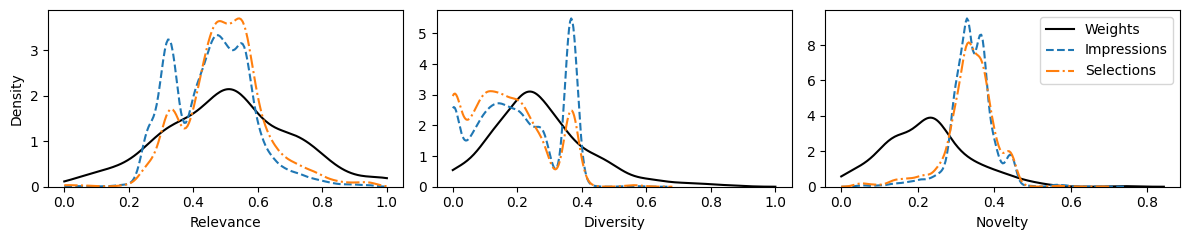

In [76]:
fig, ax = plt.subplots(1,3, figsize=(12,2.5))

sns.kdeplot(dfGroupedWeights, x="relevanceWeight", color=(0,0,0), clip=(0,1), label="Weights", ax=ax[0])
sns.kdeplot(dfShownNormImpressions, x="relevanceGain",  common_norm=False, clip=(0,1), linestyle="--", label="Impressions", ax=ax[0]) #hue="algorithm",
sns.kdeplot(dfShownNormSelections, x="relevanceGain",  common_norm=False, linestyle="-.", clip=(0,1), label="Selections", ax=ax[0])


sns.kdeplot(dfGroupedWeights, x="diversityWeight", color=(0,0,0), clip=(0,1), label="Weights", ax=ax[1])
sns.kdeplot(dfShownNormImpressions, x="diversityGain",  common_norm=False, clip=(0,1), linestyle="--", label="Impressions", ax=ax[1]) #hue="algorithm",
sns.kdeplot(dfShownNormSelections, x="diversityGain",  common_norm=False, linestyle="-.", clip=(0,1), label="Selections", ax=ax[1])


sns.kdeplot(dfGroupedWeights, x="noveltyWeight", color=(0,0,0), clip=(0,1), label="Weights", ax=ax[2])
sns.kdeplot(dfShownNormImpressions, x="noveltyGain",  common_norm=False, clip=(0,1), linestyle="--", label="Impressions", ax=ax[2]) #hue="algorithm",
sns.kdeplot(dfShownNormSelections, x="noveltyGain",  common_norm=False, linestyle="-.", clip=(0,1), label="Selections", ax=ax[2])

ax[2].legend()
ax[0].set_xlabel("Relevance")
ax[1].set_xlabel("Diversity")
ax[1].set_ylabel("")
ax[2].set_xlabel("Novelty")
ax[2].set_ylabel("")
plt.tight_layout()
plt.savefig("./results/weights_impressions_selections_distrib.pdf")